# Multi Digit MNIST Dataset with Distribution

In [24]:
import asyncio
import random

import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

num_of_digits = 4
train_imgs_to_gen = 120000 # 960000 1920000
test_img_to_gen = 30000 # 240000 480000
distribution='uniform'

dataset_path = "../../data"

In [25]:
def generate_numbers_with_distribution(num_of_digits: int, size_of_dataset: int, distribution: str):
    dataset = []
    
    if distribution == "uniform":
        for _ in range(size_of_dataset):
            number = "".join(random.choices('0123456789', k=num_of_digits))
            dataset.append(int(number))
    
    elif distribution == "normal":
        mean = 10**(num_of_digits-1)
        std_dev = mean // 10
        
        for _ in range(size_of_dataset):
            number = max(0, int(random.normalvariate(mean, std_dev)))
            dataset.append(number)
    
    return dataset

In [26]:
class MNISTNumberGenerator:
    def __init__(self, training: bool):
        self.training = training
        self.transform = transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        self.data_loaders = self.get_split_dataset_by_class()

    def get_split_dataset_by_class(self):
        '''Creates a data loader for each digit'''
        split_data_loaders: list[DataLoader] = []
        for digit in range(10):
            dataset = datasets.MNIST(
                dataset_path,
                train=self.training,
                download=True,
                transform=self.transform,
            )
            idx = dataset.targets == digit # Get a list of indices where the label matches the given digit 
            dataset.targets = dataset.targets[idx] # Remove all indices that don't match the given digit
            dataset.data = dataset.data[idx] # Get the data from the indices where the label matches the given digit
            split_data_loaders.append(
                DataLoader(
                    dataset,
                    batch_size=1,
                    shuffle=True,
                )
            ) # Create a DataLoader using the data that's left

        return split_data_loaders

    async def create_mnist_image_from_number(self, number: int):
        digits = [int(digit) for digit in str(number)] # Convert the number to a list containing it's digits
        while len(digits) < num_of_digits:
            digits.insert(0, 0)
        images = [
            next(iter(self.data_loaders[digit]))[0] for digit in digits
        ] # Choose a random image from the single digit data loader for each digit
        image = torch.cat(images, dim=3)[0][0] # Combine the images for each single digit
        label = str(number)
        while len(label) < num_of_digits:
            label = '0' + label
        return (image, label)

    def show_image(self, image: torch.Tensor, label: str):
        fig = plt.imshow(image, cmap="gray", interpolation="none")
        plt.title(label)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        
class MNISTNumbersDataset(Dataset):
    def __init__(self, numbers_list: list[int], data_with_labels: list[tuple[torch.Tensor, str]]):
        self.numbers_list = numbers_list
        self.data_with_labels = data_with_labels

    def __len__(self):
        return len(self.numbers_list)

    def __getitem__(self, idx):
        image = self.data_with_labels[idx][0]
        label = self.data_with_labels[idx][1]
        return image, label

In [27]:
# Create the data sets

training_numbers = generate_numbers_with_distribution(num_of_digits=num_of_digits, size_of_dataset=train_imgs_to_gen, distribution=distribution)
training_generator = MNISTNumberGenerator(training=True)
training_results = await asyncio.gather(*map(training_generator.create_mnist_image_from_number, training_numbers))
training_dataset = MNISTNumbersDataset(numbers_list=training_numbers, data_with_labels=training_results)

test_numbers = generate_numbers_with_distribution(num_of_digits=num_of_digits, size_of_dataset=test_img_to_gen, distribution=distribution)
test_generator = MNISTNumberGenerator(training=False)
test_results = await asyncio.gather(*map(test_generator.create_mnist_image_from_number, test_numbers))
test_dataset = MNISTNumbersDataset(numbers_list=test_numbers, data_with_labels=test_results)

In [ ]:
# Visualize the distribution of numbers

plt.hist(test_numbers, bins=10**num_of_digits, edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Histogram of Numbers')
plt.show()

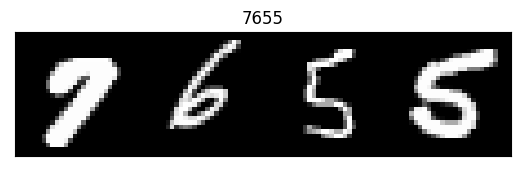

In [28]:
# Visualize the dataset
# Each time this cell is run, a random image from the dataset will be displayed along with it's label

i = random.randint(0, len(test_results) - 1)
test_generator.show_image(test_results[i][0], test_results[i][1])

In [30]:
torch.save(training_dataset, f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_{distribution}_distribution_train_data')
torch.save(training_dataset, f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_{distribution}_distribution_test_data')

In [ ]:
training_dataset = torch.load(f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_{distribution}_distribution_train_data')
training_dataset = torch.load(f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_{distribution}_distribution_digit_test_data')